# Prostate Pathology Classifier 

The following project will use a convolutional neural network to classify whole slide images(WSI) of prostate pathology. The original CNN will use an Inception V3 model comined with an augmentation algorithm to train the model.

According to Jerome Cheng, MD, who pulbished a short summary on computational pathology on July 2020, its is more ideal to use a pre-trained CNN such as VGG-16, VGG-19, ResNet50 or Inception v3. The reason being, that features embedded inside these neural networks can be used to train a classifier for pathology whole slide images. A working example of this model can be found in a study by Iizuka, O., Kanavati, F., Kato, K. et al.(see link below), who used an augmented Inception V3 model to train a deep learning model that recognizes whole slide images of gastric and epithelian tumors. I will therefore use my own customized augmente Inception V3 model to train on a prostate cancer dataset. 

- Computationa Pathology by Jerome Cheng, MD: https://www.pathologyoutlines.com/topic/informaticsconvnet.html
- Deep Learning Models for Histopathological Classification of Gastric and Colonic Epithelial Tumours: https://www.nature.com/articles/s41598-020-58467-9

In [126]:
import tensorflow as tf
from tensorflow.keras import layers
#from tensorflow import keras
import os
#from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3


### Define Constants

In [127]:
IMAGES_PATH = "data_prostate/images/train_images/"
LABELS_PATH = "data_prostate/labels/train.csv"

INPUT_SHAPE = (224, 224, 3)

RANDOM_STATE = 97

### Loading the Data

#### I. Loading the Labels

In [128]:
patho_csv = pd.read_csv(LABELS_PATH,index_col=0)
patho_csv.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [129]:
patho_csv.shape

(10616, 3)

In [130]:
isups = patho_csv.isup_grade.value_counts()

<AxesSubplot:>

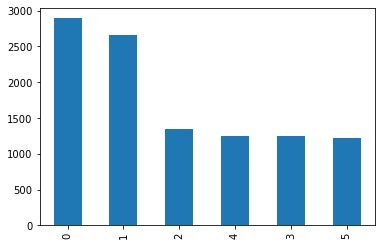

In [131]:
isups.plot.bar()

#### II. Adding a Binary Classification Column

I will experiment with building 2 different types of models:
- Binary classification -> 1 = suspect cancer, 0 = low cancer probability
- A multi classification model based on the ISUP grading (usung a One-Hot-Encoder)

For the binary classification part I will add an extra column called `binary_class` where any ISUP score above 1 will be classified as being suspect

In [132]:
bool_benign = patho_csv.isup_grade <= 1
patho_csv.loc[bool_benign, 'binary_class'] = 0

bool_malignant = patho_csv.isup_grade > 1
patho_csv.loc[bool_malignant, 'binary_class'] = 1


In [133]:
patho_csv.head()

,data_provider,isup_grade,gleason_score,binary_class
image_id,,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0.0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,0.0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1.0
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1.0
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0.0


#### III. Loading the Images

I will load images using the following steps:
- create a label train set from our labels y_train, y_test
- create an image training set based on our y_train image_id, x_train, x_test


In [134]:
# create a list of all the images names
#image_dir=os.listdir(IMAGES_PATH)

image_dir = patho_csv.index


In [135]:
# Load images based on the patho_csv dataframe index

def get_image_list(target_dataframe: pd.DataFrame,max_range:int):
    target_index = target_dataframe.index
    ''' Load a lit of images, based on the index of the patho_csv dataframe
    Input: 
        DataFrame: Target dataframe
        max_range:  No. of max images
        
    Output is a tupule of:
        List of images up to max_range
        dataframe slice up to max_range
    '''
    image_list = []
    for img,i in zip(target_index, range(max_range)):
        if img != '.DS_Store':
            ext_img = image.load_img(str(IMAGES_PATH+img+'.png'), target_size=INPUT_SHAPE)
            image_list.append(ext_img)

    y_train_df = target_dataframe.iloc[:max_range]
    return image_list, y_train_df


In [136]:

# This is a list of all the images - X_train_list
# This is a list of all the labels - y_train_list
X_list,y_df = get_image_list(patho_csv,20)


### Train, Test and Split

In this section I will split the images and corresponding labels into training and testing dataset

In [176]:
X_train, X_test, y_train_df, y_test_df = train_test_split(X_list, y_df, test_size=0.20, random_state=RANDOM_STATE)
y_train_df.shape, len(X_train)

((16, 4), 16)

### Convert Test and Train for AI Model

In [172]:
# Convert images to numpy array
def create_feature_label_array(image_list):
    '''Return a numpy array of all images'''
    feature_images= []
    for image in image_list:
        data = np.asarray( image )
        feature_images.append(data)

    feature_images = np.array(feature_images)
    return feature_images

In [173]:
# Create a numpy array of all images
X_train_np = create_feature_label_array(X_train)

# Rescale X_train_np
X_train_np = X_train_np / 255.0

In [177]:
y_train_df.head()

,data_provider,isup_grade,gleason_score,binary_class
image_id,,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,0.0
006f4d8d3556dd21f6424202c2d294a9,karolinska,0,0+0,0.0
003046e27c8ead3e3db155780dc5498e,karolinska,1,3+3,0.0
004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3,0.0
007433133235efc27a39f11df6940829,radboud,0,negative,0.0


In [178]:
y_train = y_train['binary_class'].values

In [169]:
# Create a numpy array of all labels
y_train = y_df

In [179]:
X_train_np.shape, y_train.shape

((16, 224, 224, 3), (16,))

### Creating a CNN Model

#### I. Instantiating Inception V3 and Exploring the Model

In [141]:
# Instantiate the InceptionV3 model and drop the top layer
inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

In [142]:
# There are 311 layer in the pretrained Inception V3 model
len(inception_model.layers)

311

In [143]:
# Freeze all layers:
for layer in inception_model.layers:
    layer.trainable = False

In [144]:
print(tf.__version__)

2.0.0


In [150]:
#augment_images= tf.keras.Sequential([
    #tensorflow.image.random_flip_left_right(Image),
#    layers.RandomFlip("horizontal_and_vertical"),
    #layers.experimental.preprocessing.RandomFlip("horizontal"),
#    tf.keras.layers.RandomRotation(0.2)
    #tf.keras.layers.experimental.preprocessing.RandomBrightness(0.2),
    #tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", seed=RANDOM_STATE),
    #tf.keras.layers.experimental.preprocessing.RandomFlip("vertical", seed=RANDOM_STATE)
#])

In [148]:
patho_model_main = tf.keras.Sequential([
    #augment_images,
    inception_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32, activation='relu'),

    # Flateen the layers to a 1D vector and use a dropout layer to prevent overfitting
    layers.Flatten(),
    layers.Dropout(0.5),

    # Final output layer, with 1 node and sigmoid activation because we are
    # training a binary classifier:
    layers.Dense(1, activation='sigmoid')
])

In [151]:
batch_size = 100
epochs = 1

In [152]:
patho_model_main.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [180]:
patho_model_main.fit(X_train_np, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)




Train on 14 samples, validate on 2 samples
14/14 [==============================] - 9s 609ms/sample - loss: 0.6304 - accuracy: 0.5714 - val_loss: 1.9773 - val_accuracy: 0.5000


In [ ]:
patho_model_main.save("patho_alpha_model.h5")